<a href="https://colab.research.google.com/github/iqbalkap/PruningDistillation/blob/main/Fix_Distiller_BiLSTM_Grafik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Knowledge Distillation**





In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Bidirectional
    )


train = pd.read_csv('/content/drive/MyDrive/Dataset VAE/uncalibrated/train_final_u/train_21_u.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset VAE/uncalibrated/valid_final_u/valid_21_u.csv')


#del variabel yang tidak dipakai
train = train.drop(['Timestamp', 'Cycle', 'Active Button'], axis=1)
test = test.drop(['Timestamp', 'Cycle', 'Active Button'], axis=1)

print('Input train shape :', train.shape)
print('Input test shape :', test.shape)

Input train shape : (91000, 10)
Input test shape : (41600, 10)


In [ ]:
# Prepare the train and test dataset.

n_ts = 100 #bebas
n_outputs = 4
n_features = 10

x_train = (train.values[:,0:10])
xt = int(x_train.shape[0]/n_ts) #ubah ke 3D
print('x_train_samples =',xt)
x_train = x_train.reshape((xt, n_ts, 10))
x_train = x_train.astype('float32')
y_train = pd.read_csv('/content/drive/MyDrive/Dataset VAE/hasil_labeling_train_u.csv') #label train
y_train = y_train.astype('float32')

x_test = (test.values[:,0:10])
xs = int(x_test.shape[0]/n_ts)
print('x_test_samples =',xs)
x_test = x_test.reshape((xs,n_ts,10))
x_test = x_test.astype('float32')
y_test = pd.read_csv('/content/drive/MyDrive/Dataset VAE/hasil_labeling_valid_u.csv') #label test
y_test = y_test.astype('float32')

######################
y_train = y_train - 1
y_test = y_test - 1

print('Shape final')
x_train.shape,y_train.shape, x_test.shape, y_test.shape


x_train_samples = 910
x_test_samples = 416
Shape final


((910, 100, 10), (910, 1), (416, 100, 10), (416, 1))

In [ ]:
# Create the teacher's model
teacher = keras.Sequential(
    [
        keras.Input(shape=(n_ts,n_features)),
        layers.Bidirectional(LSTM(100, activation='tanh')),
        layers.Dropout(0.5),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax'),
    ],

    name="teacher",
)
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              88800     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 109,304
Trainable params: 109,304
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create the student's model
student = keras.Sequential(
    [
        keras.Input(shape=(n_ts,n_features)),
        layers.Bidirectional(LSTM(47, activation='tanh')),
        layers.Dropout(0.5),
        layers.Dense(n_outputs),
    ],
    name="student",
)
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 94)               21808     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 94)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 380       
                                                                 
Total params: 22,188
Trainable params: 22,188
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [ ]:
import time

start_time = time.perf_counter()

# Train teacher as usual
teacher.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

#checkpoint dan save weight untuk teacher
filepath="weights.teacher.hdf5"
checkpoint_teacher = ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
#es_teacher = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10)
callbacks_teacher_list = [checkpoint_teacher]



#Run teacher RUN!!!
#Fit the model
history = teacher.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=64, callbacks=callbacks_teacher_list, verbose=2)

print (time.perf_counter() - start_time, "seconds")


Epoch 1/300

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.85577, saving model to weights.teacher.hdf5
15/15 - 10s - loss: 1.2623 - sparse_categorical_accuracy: 0.4495 - val_loss: 0.8343 - val_sparse_categorical_accuracy: 0.8558 - 10s/epoch - 679ms/step
Epoch 2/300

Epoch 2: val_sparse_categorical_accuracy improved from 0.85577 to 0.95673, saving model to weights.teacher.hdf5
15/15 - 0s - loss: 0.7516 - sparse_categorical_accuracy: 0.7670 - val_loss: 0.4100 - val_sparse_categorical_accuracy: 0.9567 - 451ms/epoch - 30ms/step
Epoch 3/300

Epoch 3: val_sparse_categorical_accuracy improved from 0.95673 to 0.96635, saving model to weights.teacher.hdf5
15/15 - 0s - loss: 0.4400 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.2222 - val_sparse_categorical_accuracy: 0.9663 - 482ms/epoch - 32ms/step
Epoch 4/300

Epoch 4: val_sparse_categorical_accuracy improved from 0.96635 to 0.98798, saving model to weights.teacher.hdf5
15/15 - 1s - loss: 0.3096 - sparse_categorical_acc

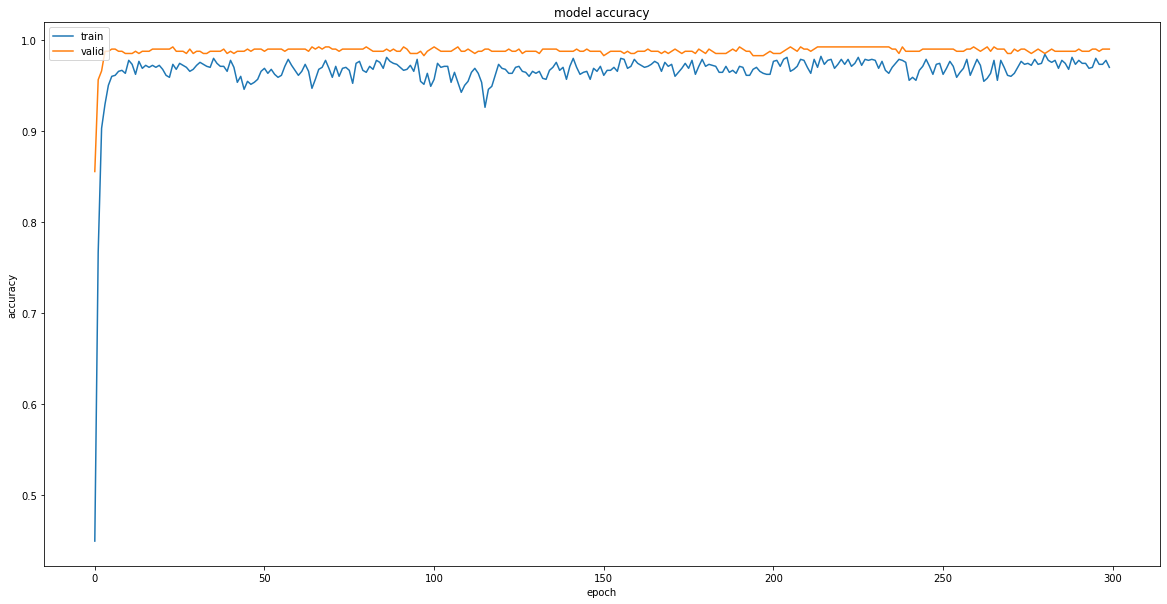

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplots_adjust(hspace=1)
plt.rc('font', size=15)
fig = plt.gcf()
fig.set_size_inches(20, 10)

plt.show()

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
#Train student as does usually
student.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

student.save("student.h5")
teacher.save("teacher.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

historyt = distiller.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=2)

historys =  distiller.evaluate(x_test, y_test, batch_size=64, verbose=2)

hist_df = pd.DataFrame(historyt.history)

hist_csv_file = '15000historyBiLSTM33.csv'
with open(hist_csv_file, mode='w') as f:
    		hist_df.to_csv(f)

Epoch 1/50
15/15 - 5s - sparse_categorical_accuracy: 0.2736 - student_loss: 1.5229 - distillation_loss: 0.2544 - val_sparse_categorical_accuracy: 0.4399 - val_student_loss: 1.2413 - 5s/epoch - 317ms/step
Epoch 2/50
15/15 - 0s - sparse_categorical_accuracy: 0.3989 - student_loss: 1.1471 - distillation_loss: 0.1503 - val_sparse_categorical_accuracy: 0.7861 - val_student_loss: 1.1537 - 268ms/epoch - 18ms/step
Epoch 3/50
15/15 - 0s - sparse_categorical_accuracy: 0.5000 - student_loss: 1.2149 - distillation_loss: 0.1779 - val_sparse_categorical_accuracy: 0.9111 - val_student_loss: 1.0722 - 249ms/epoch - 17ms/step
Epoch 4/50
15/15 - 0s - sparse_categorical_accuracy: 0.5462 - student_loss: 1.0846 - distillation_loss: 0.0978 - val_sparse_categorical_accuracy: 0.9712 - val_student_loss: 1.0261 - 266ms/epoch - 18ms/step
Epoch 5/50
15/15 - 0s - sparse_categorical_accuracy: 0.5934 - student_loss: 1.1744 - distillation_loss: 0.1167 - val_sparse_categorical_accuracy: 0.9736 - val_student_loss: 0.994

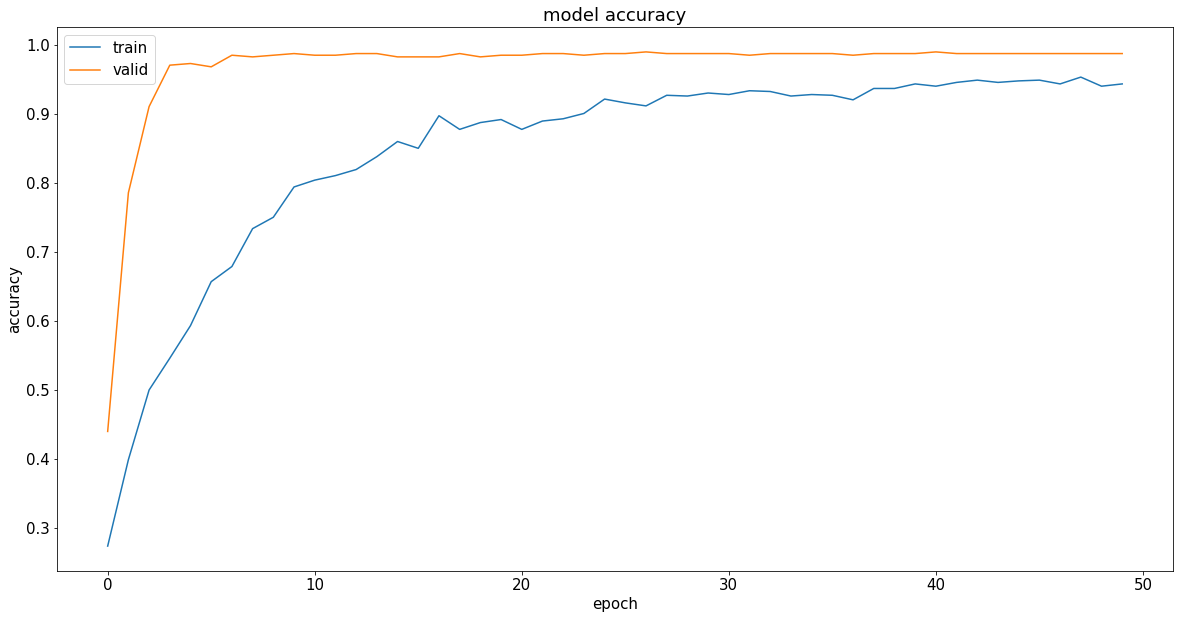

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historyt.history['sparse_categorical_accuracy'])
plt.plot(historyt.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplots_adjust(hspace=1)
plt.rc('font', size=15)
fig = plt.gcf()
fig.set_size_inches(20, 10)

plt.show()

In [ ]:
#Train student as does usually
student_scratch.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

#checkpoint dan save weight untuk student scratch
filepath="weights.student_scratch.hdf5"
checkpoint_student_scratch = ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
es_student_s = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=20)
callbacks_student_scratch_list = [checkpoint_student_scratch, es_student_s]
historyss = student_scratch.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, callbacks=callbacks_student_scratch_list, verbose=2)

Epoch 1/50

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.44231, saving model to weights.student_scratch.hdf5
15/15 - 4s - loss: 4.1937 - sparse_categorical_accuracy: 0.3505 - val_loss: 2.4374 - val_sparse_categorical_accuracy: 0.4423 - 4s/epoch - 245ms/step
Epoch 2/50

Epoch 2: val_sparse_categorical_accuracy improved from 0.44231 to 0.64183, saving model to weights.student_scratch.hdf5
15/15 - 0s - loss: 3.3593 - sparse_categorical_accuracy: 0.4209 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.6418 - 254ms/epoch - 17ms/step
Epoch 3/50

Epoch 3: val_sparse_categorical_accuracy improved from 0.64183 to 0.72115, saving model to weights.student_scratch.hdf5
15/15 - 0s - loss: 3.0225 - sparse_categorical_accuracy: 0.4582 - val_loss: 0.8432 - val_sparse_categorical_accuracy: 0.7212 - 217ms/epoch - 14ms/step
Epoch 4/50

Epoch 4: val_sparse_categorical_accuracy improved from 0.72115 to 0.75721, saving model to weights.student_scratch.hdf5
15/15 - 0s - loss: 2.632

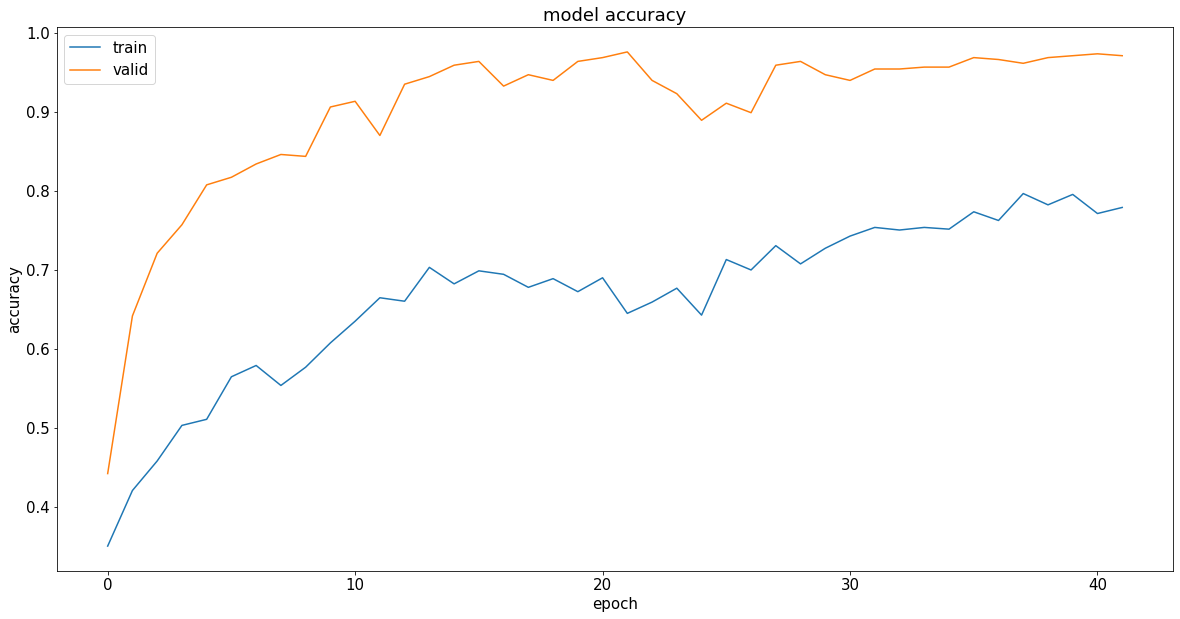

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historyss.history['sparse_categorical_accuracy'])
plt.plot(historyss.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.subplots_adjust(hspace=1)
plt.rc('font', size=15)
fig = plt.gcf()
fig.set_size_inches(20, 10)

plt.show()

#Predict

In [ ]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model
 
# load model
students = tf.keras.models.load_model("/content/student.h5")
students.load_weights("/content/student.h5")


In [ ]:
import time

start_time = time.perf_counter()

loss, accuracy = students.evaluate(x_test, y_test,batch_size=64, verbose=1)

print (time.perf_counter() - start_time, "seconds")

7/7 [==============================] - 1s 9ms/step - loss: 9.3707 - sparse_categorical_accuracy: 0.1466
0.8305421829999204 seconds


In [ ]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
teachers = tf.keras.models.load_model("/content/teacher.h5")
teachers.load_weights("/content/teacher.h5")


In [ ]:
import time

start_time = time.perf_counter()

loss, accuracy = teachers.evaluate(x_test, y_test, verbose=1)
print (time.perf_counter() - start_time, "seconds")

13/13 [==============================] - 1s 9ms/step - loss: 0.0792 - sparse_categorical_accuracy: 0.9904
0.8091526569999132 seconds


In [ ]:
# Play an audio beep. Any audio URL will do.
#from google.colab import output
#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')